In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())


In [139]:
data = pd.read_csv('C:/Users/abdul/Downloads/TRYX.csv')
data = data.dropna()
data.head()
data.dropna()
data.isnull().sum()
print(data.head()) #7 columns, including the Date. 

         Date     Open     High      Low    Close  Adj Close  Volume
0  2013-01-01  1.78180  1.78180  1.78180  1.78180    1.78180     0.0
1  2013-01-02  1.78140  1.78200  1.77400  1.78140    1.78140     0.0
2  2013-01-03  1.77778  1.78250  1.77648  1.77778    1.77778     0.0
3  2013-01-04  1.78560  1.79053  1.78364  1.78420    1.78420     0.0
4  2013-01-07  1.78058  1.78624  1.77900  1.78048    1.78048     0.0


In [140]:
train_dates = pd.to_datetime(data['Date'])
print(len(train_dates)) #Check last few dates. 

2882


In [141]:
cols = list(data)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close', 'Adj Close']


In [164]:
df_for_training = data[cols].astype(float)
train_size = int(0.7 * len(df_for_training))
train_data, test_data = df_for_training[:train_size], df_for_training[train_size:]
train_data_date, test_data_date = train_dates[:train_size], train_dates[train_size:]


print(len(train_data), len(test_data_date),len(train_data_date), len(test_data_date)) #Check last few dates. 


2017 865 2017 865


In [165]:
scaler = StandardScaler()
df_for_training_scaled = scaler.fit_transform(train_data)
df_for_testing_scaled = scaler.transform(test_data)

In [166]:
target = 'Adj Close'

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

In [167]:
def create_dataset(data_scaled, data_original, n_past, n_future, target_col):
    X, y = [], []
    for i in range(n_past, len(data_scaled) - n_future + 1):
        X.append(data_scaled[i - n_past:i])
        y.append(data_scaled[i+n_future-1][-1])
    return np.array(X), np.array(y)

In [168]:
trainX, trainY = create_dataset(df_for_training_scaled, train_data, n_past, n_future, target)
testX, testY = create_dataset(df_for_testing_scaled, test_data, n_past, n_future, target)


print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))


trainX shape == (2003, 14, 5).
trainY shape == (2003,).
testX shape == (851, 14, 5).
testY shape == (851,).


In [169]:
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(16, activation='tanh', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

C:\Users\abdul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 14, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 16)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,121 (90.32 KB)

 Trainable params: 23,121 (90.32 KB)

 Non-trainable params: 0 (0.00 B)

In [170]:
history = model.fit(x=trainX, y= trainY, epochs= 100, batch_size= 32)

plt.plot(history.history['loss'], label='Training loss')
plt.legend()

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2804
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0331
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0243
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0267
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0252
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0221
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0197
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0205
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0211
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0206
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0182
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0188
Epoch 13/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0196
Epoch 14/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0202
Epoch 15/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0187
Epoc

In [160]:
#n_days_for_prediction= int(len(data))

trainPeriod = int(len(train_data_date))
testPeriod = int(len(test_data_date))

train_predict_period_dates = pd.date_range(list(train_dates)[0], periods=trainPeriod, freq=us_bd).tolist()
test_predict_period_dates = pd.date_range(list(train_dates)[trainPeriod], periods=testPeriod, freq=us_bd).tolist()

print(train_predict_period_dates)
print(test_predict_period_dates)


#Make prediction for test
prediction_test = model.predict(testX[-testPeriod:])
prediction_train = model.predict(trainX[-trainPeriod:])

print(prediction_train.shape, prediction_test.shape)

[Timestamp('2013-01-02 00:00:00'), Timestamp('2013-01-03 00:00:00'), Timestamp('2013-01-04 00:00:00'), Timestamp('2013-01-07 00:00:00'), Timestamp('2013-01-08 00:00:00'), Timestamp('2013-01-09 00:00:00'), Timestamp('2013-01-10 00:00:00'), Timestamp('2013-01-11 00:00:00'), Timestamp('2013-01-14 00:00:00'), Timestamp('2013-01-15 00:00:00'), Timestamp('2013-01-16 00:00:00'), Timestamp('2013-01-17 00:00:00'), Timestamp('2013-01-18 00:00:00'), Timestamp('2013-01-22 00:00:00'), Timestamp('2013-01-23 00:00:00'), Timestamp('2013-01-24 00:00:00'), Timestamp('2013-01-25 00:00:00'), Timestamp('2013-01-28 00:00:00'), Timestamp('2013-01-29 00:00:00'), Timestamp('2013-01-30 00:00:00'), Timestamp('2013-01-31 00:00:00'), Timestamp('2013-02-01 00:00:00'), Timestamp('2013-02-04 00:00:00'), Timestamp('2013-02-05 00:00:00'), Timestamp('2013-02-06 00:00:00'), Timestamp('2013-02-07 00:00:00'), Timestamp('2013-02-08 00:00:00'), Timestamp('2013-02-11 00:00:00'), Timestamp('2013-02-12 00:00:00'), Timestamp('20

In [161]:
#train data
trainPredict_copies = np.repeat(prediction_train, df_for_training.shape[1], axis=-1)
y_pred_train = scaler.inverse_transform(trainPredict_copies)[:, 0]


#test data
testPredict_copies = np.repeat(prediction_test, df_for_training.shape[1], axis=-1)
y_pred_test = scaler.inverse_transform(testPredict_copies)[:, 0]

print(y_pred_train.shape,trainY.shape, df_for_training.shape[0], len(prediction_test), trainPredict_copies.shape)

train_error = mean_squared_error(trainY, y_pred_train)
test_error = mean_squared_error(testY, y_pred_test)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_test= mean_absolute_percentage_error(testY, y_pred_test)

print(f"MAPE: {mape_test:.2f}%")

print(f"Train data MSE: {train_error:.2f}%")
print(f"Test data MSE: {test_error:.2f}%")


(1427,) (1427,) 2882 1427 (1427, 5)
MAPE: 43.49%
Train data MSE: 8.15%
Test data MSE: 138.53%


In [162]:
train_forecast_dates, test_forecast_dates = [], []

passDay = 0

for time_i in train_predict_period_dates:
    if passDay >= n_past:
        train_forecast_dates.append(time_i.date())
    passDay = passDay + 1

passDay = 0
for time_i in test_predict_period_dates:
    if passDay>=n_past:
        test_forecast_dates.append(time_i.date())
    passDay = passDay +1

print(len(test_forecast_dates), len(y_pred_test), len(train_forecast_dates), len(y_pred_train))

df_forecast_test = pd.DataFrame({'Date':np.array(test_forecast_dates), 'Adj Close':y_pred_test})
df_forecast_test['Date']=pd.to_datetime(df_forecast_test['Date'])

df_forecast_train = pd.DataFrame({'Date':np.array(train_forecast_dates), 'Adj Close':y_pred_train})
df_forecast_train['Date'] = pd.to_datetime(df_forecast_train['Date'])

1427 1427 1427 1427


C:\Users\abdul\AppData\Local\Temp\ipykernel_10720\1959166261.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


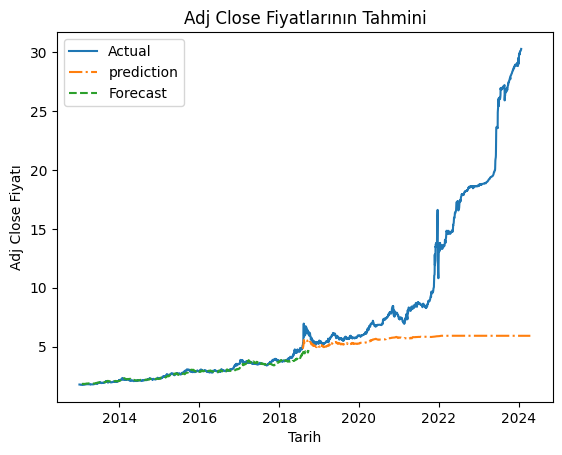

In [163]:
original = data[['Date', 'Adj Close']]
original['Date']=pd.to_datetime(original['Date'])


plt.plot(original['Date'], original['Adj Close'], label="Actual")
plt.plot(df_forecast_test['Date'], df_forecast_test['Adj Close'], label='prediction', linestyle='-.')
plt.plot(df_forecast_train['Date'], df_forecast_train['Adj Close'], label='Forecast', linestyle='--')
plt.title('Adj Close Fiyatlarının Tahmini')
plt.xlabel('Tarih')
plt.ylabel('Adj Close Fiyatı')
plt.legend()
plt.show()


